In [ ]:
#pcakges
import numpy as np                                      
import pandas as pd 
!pip install -q pycountry
import pycountry                                        
import statsmodels.api as sm                                
import seaborn as sns                                   
import matplotlib.pyplot as plt                         
from sklearn.preprocessing import MinMaxScaler          
from sklearn.cluster import KMeans                      
from scipy.optimize import curve_fit                  

In [ ]:
                  
min_max_scaler=MinMaxScaler()  

In [ ]:

#reading the data
#first 4 rows of the data contain some metadata so we skipped that rows
df = pd.read_csv("climate_indicators.csv", skiprows=4)

# Drop columns that are not required 
df = df.iloc[:, :-1]

# Create a dataset with County Name column name
country_df = df.set_index(["Country Name", "Indicator Name"])
country_df.drop(["Country Code", "Indicator Code"], axis=1, inplace=True)

# Taking transpose of the countries_Df
country_df= country_df.T

In [ ]:
indicators = [
'CO2 emissions (kt)',
'Urban population growth (annual %)',
'Cereal yield (kg per hectare)',
'Arable land (% of land area)',
'Forest area (sq. km)',
]

In [ ]:
# Filter the dataset for the required indicators
extracted_results = df[df["Indicator Name"].isin(indicators)]
# Extracting data for only countries we are interested in
countries_ls = [country.name for country in list(pycountry.countries)]
extracted_resutls = extracted_results[extracted_results["Country Name"].isin(countries_ls)]

In [ ]:
#missing values imputation
data = extracted_resutls.fillna(method='ffill').fillna(method='bfill')
pivot_table = data.pivot_table(index='Country Name', columns='Indicator Name', values='2020')

Text(0.5, 1.0, 'Countries Standing by Arable land (% of land area)')

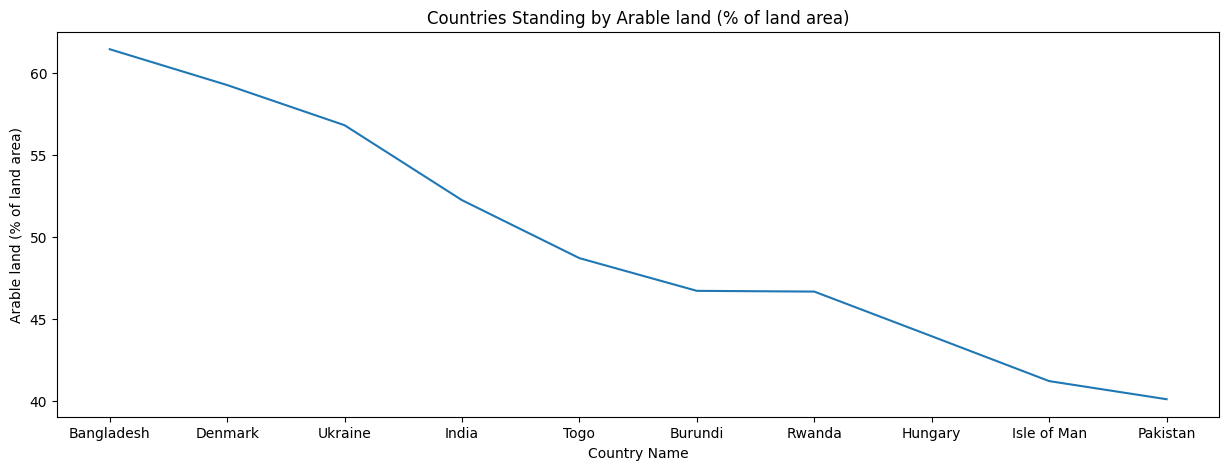

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(pivot_table['Arable land (% of land area)'].sort_values(ascending=False)[0:10])
plt.title('Countries Standing by Arable land (% of land area)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


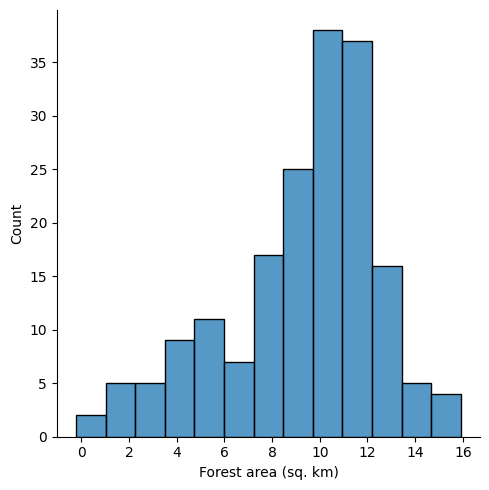

In [ ]:
sns.displot(np.log(pivot_table['Forest area (sq. km)']))
plt.title('Distribution of Forest Area in Sq)')  #this data is plotted data log transformation

<BarContainer object of 10 artists>

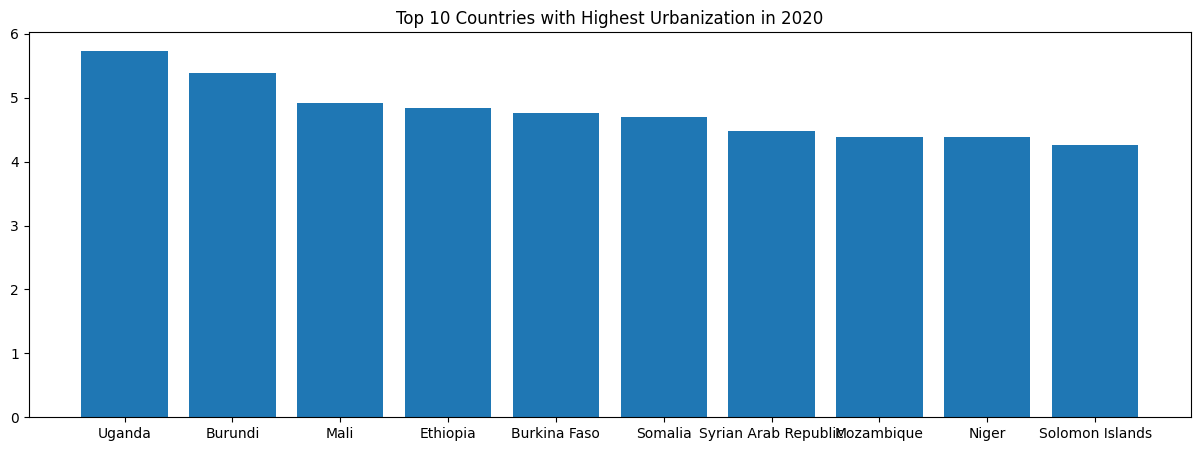

In [ ]:
ub_growth=pivot_table['Urban population growth (annual %)'].sort_values(ascending=False)[0:10]
plt.figure(figsize=(15,5))
plt.title('Top 10 Countries with Highest Urbanization in 2020')
plt.bar(x=ub_growth.index,height=ub_growth.values)

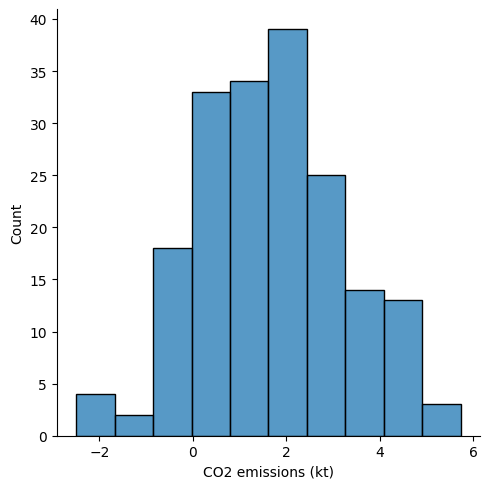

In [ ]:
sns.displot(pivot_table['CO2 emissions (kt)'])
plt.title('Distribution of CO2 for 2020')

In [ ]:
# data Normalization
scaled_data = min_max_scaler.fit_transform(pivot_table.values)
min=np.min(pivot_table.values)
max=np.max(pivot_table.values)


In [ ]:
# number of clusters
num_clusters = 3

In [ ]:
#KMeans Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=22)
cluster_labels = kmeans.fit_predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Add the cluster labels to the dataset
pivot_table["Cluster"] = cluster_labels
pivot_table.groupby("Cluster").mean()
labels = indicators

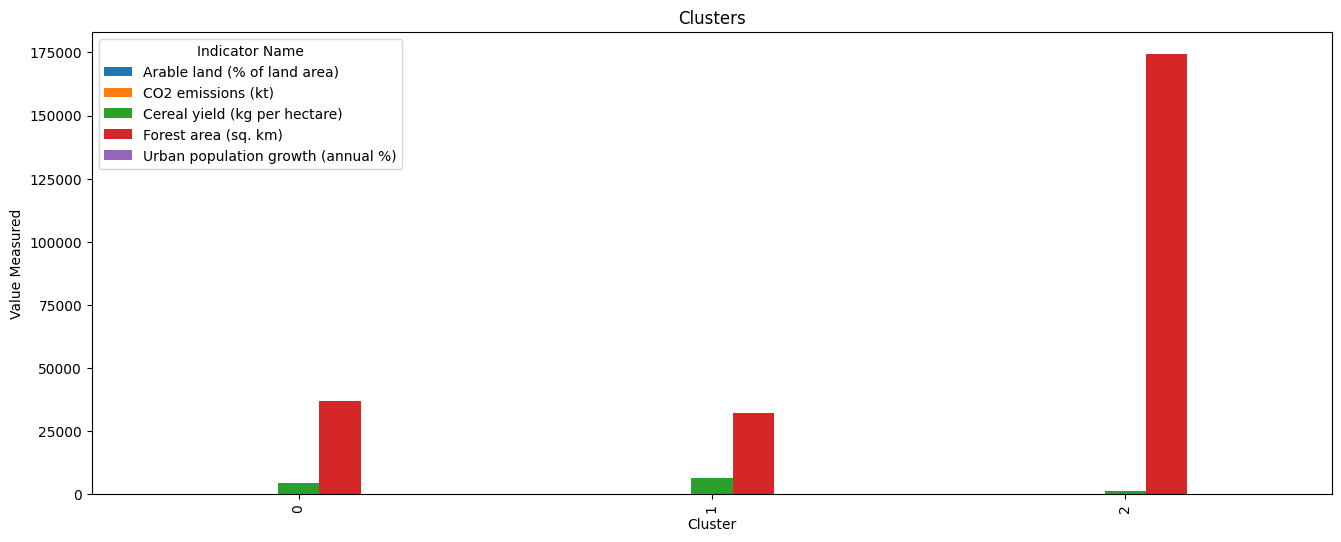

In [ ]:
# Selecting one country from each cluster
pivot_table.groupby("Cluster").last()

# Comparing values for each country
pivot_table.groupby("Cluster").last().plot(kind="bar", figsize=(16, 6))
plt.title("Clusters")
plt.ylabel("Value Measured")
plt.show()

In [ ]:
def ln_function(x, a, b):
    return a*x + b

def model(x_values, y_values, linear_func, sigma=[1.0, 1.0]):
    popt, pcov = curve_fit(linear_func, x_values, y_values)
    x_pred = np.arange(2020, 2030)
    y_pred = ln_function(x_pred, *popt)



    # Estimate CI for predicted values
    model = sm.OLS(y_values, sm.add_constant(x_values))
    fitted_model = model.fit()
    prediction = fitted_model.get_prediction(sm.add_constant(x_pred))
    mean_values = prediction.predicted_mean
    lower = prediction.conf_int()[:, 0]
    upper = prediction.conf_int()[:, 1]

    
    
    print("Predictions",y_pred)
    
    
    
    plt.figure(figsize=(12, 5))
    plt.plot(x_values, y_values, '1', label='The Data',color='red')
    plt.plot(x_pred, y_pred, 'r-', label='Forcasted',color='black')
    plt.fill_between(x_pred, lower, upper, color='red', alpha=0.2, label='CI')
    plt.legend(loc='best')
    plt.title("Population, total")
    plt.xlabel('Year')
    plt.ylabel('Total Population')
    plt.show()

Predictions [7.77699341e+09 7.85871446e+09 7.94043550e+09 8.02215654e+09
 8.10387759e+09 8.18559863e+09 8.26731968e+09 8.34904072e+09
 8.43076176e+09 8.51248281e+09]


<ipython-input-76-1e8fa71cca12>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_pred, y_pred, 'r-', label='Forcasted',color='black')


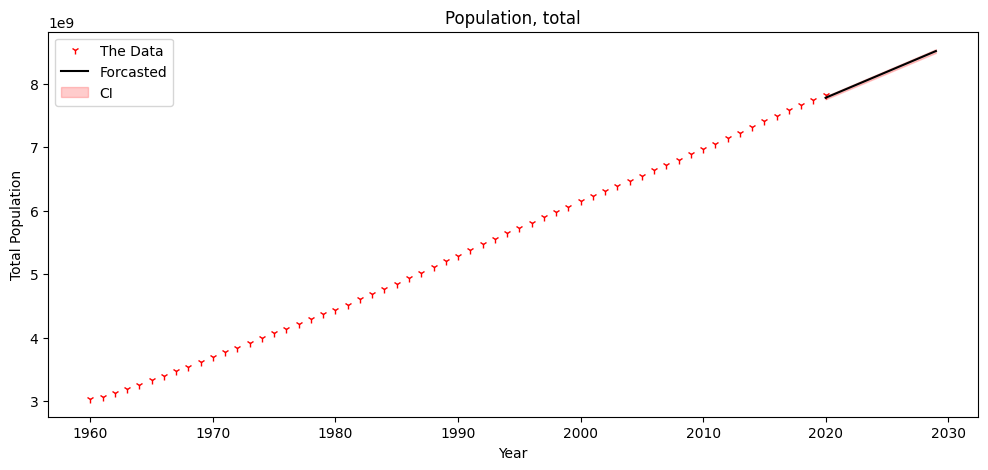

In [ ]:
#getting required data to get train our model
values = country_df[("World", "Population, total")]

X = values.index.astype("int")
y = values.values.astype("float64")

model(X, y, ln_function)